In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import gc
from sklearn.metrics import accuracy_score, f1_score as f1, classification_report
from tensorflow.keras.utils import to_categorical
import random

# Load Data

In [2]:
X_train = pd.read_csv('/Users/aimeewilliams/Downloads/drive-download-20241209T000309Z-001/X_train.csv')
X_val = pd.read_csv('/Users/aimeewilliams/Downloads/drive-download-20241209T000309Z-001/X_val.csv')
X_test = pd.read_csv('/Users/aimeewilliams/Downloads/drive-download-20241209T000309Z-001/X_test.csv')
y_train = pd.read_csv('/Users/aimeewilliams/Downloads/drive-download-20241209T000309Z-001/y_train.csv')
y_val = pd.read_csv('/Users/aimeewilliams/Downloads/drive-download-20241209T000309Z-001/y_val.csv')
y_test = pd.read_csv('/Users/aimeewilliams/Downloads/drive-download-20241209T000309Z-001/y_test.csv')

# Binary Models: Mental Health related vs. Normal

Baseline Model: majority class predictor

In [3]:
#Convert labels to either 0 (normal) or 1 (abnormal) for binary model
# Map the labels into two categories: 'normal' and 'abnormal'
y_train_binary = np.where(y_train == 3, 0, 1)  # 0 for 'Normal', 1 for 'Abnormal'
y_val_binary = np.where(y_val == 3, 0, 1)
y_test_binary = np.where(y_test == 3, 0, 1)

# Verify the transformation
print("Binary labels distribution:")
print(f"Training set - Normal: {np.sum(y_train_binary == 0)}, Abnormal: {np.sum(y_train_binary == 1)}")
print(f"Validation set - Normal: {np.sum(y_val_binary == 0)}, Abnormal: {np.sum(y_val_binary == 1)}")
print(f"Test set - Normal: {np.sum(y_test_binary == 0)}, Abnormal: {np.sum(y_test_binary == 1)}")

Binary labels distribution:
Training set - Normal: 9616, Abnormal: 21908
Validation set - Normal: 3308, Abnormal: 7200
Test set - Normal: 3281, Abnormal: 7228


In [4]:
#predicting majority class, abnormal
y_pred_majority = np.ones_like(y_test_binary)
majority_accuracy = accuracy_score(y_test_binary, y_pred_majority)
print(f"Majority Class Accuracy: {majority_accuracy}")

Majority Class Accuracy: 0.6877914168807688


The Majority Class Classifier has an accuracy of about 69% on the test data.

Preparing text for model: count vectorization

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data and transform it into a bag-of-words representation
X_train_bow = vectorizer.fit_transform(X_train['0'])

# Transform validation and test sets using the same vectorizer
X_val_bow = vectorizer.transform(X_val['0'])
X_test_bow = vectorizer.transform(X_test['0'])

# Verify shapes
print("Training set shape:", X_train_bow.shape)
print("Validation set shape:", X_val_bow.shape)
print("Test set shape:", X_test_bow.shape)

Training set shape: (31524, 48543)
Validation set shape: (10508, 48543)
Test set shape: (10509, 48543)


In [6]:
X_train_bow = X_train_bow.astype(np.float32)
X_val_bow = X_val_bow.astype(np.float32)
X_test_bow = X_test_bow.astype(np.float32)

def reshape_for_lstm(x): # for LSTM
    dense = x.toarray()
    # turn into float32
    dense = dense.astype(np.float32)
    return dense.reshape((dense.shape[0], 1, dense.shape[1]))

In [22]:
X_train_lstm = reshape_for_lstm(X_train_bow)
X_val_lstm = reshape_for_lstm(X_val_bow)
X_test_lstm = reshape_for_lstm(X_test_bow)

#Reshape arrays to work better with tf
y_train_binary = y_train_binary.reshape(-1, 1)
y_val_binary = y_val_binary.reshape(-1, 1)
y_test_binary = y_test_binary.reshape(-1, 1)
print(y_train_binary.shape)
print(y_val_binary.shape)
print(y_test_binary.shape)

(31524, 1)
(10508, 1)
(10509, 1)


Binary Model: LTSM Model

In [9]:
# random seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def build_lstm(X_train, y_train, X_val, y_val, truncate_to: int = 40000):

  # Clear any TensorFlow session
  tf.keras.backend.clear_session()

  model = Sequential()

  # Add an LSTM layer
  model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

  # Add a Dense output layer (e.g., for binary classification)
  model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Step 6: Train the model
  model.fit(
      X_train,
      y_train,
      epochs=5, #number of cycles
      batch_size=16, #number of samples processed at a time
      validation_data=(X_val, y_val),
      callbacks=[
          EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
        ]
  )

  # Step 6.5: Add Early Stopping


  # Step 7: Evaluate the model
  loss, accuracy = model.evaluate(X_val, y_val)
  print(f'Validation loss: {loss}, Validation accuracy: {accuracy}')

  # Step 8: Make predictions
  predictions = model.predict(X_val)
  print(predictions)

  return {
      'predictions': predictions,
      'model': model,
      'loss': loss,
      'accuracy': accuracy
  }

In [10]:
model = build_lstm(X_train_lstm, y_train_binary, X_val_lstm, y_val_binary)

/Users/aimeewilliams/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.8849 - loss: 0.2669 - val_accuracy: 0.9488 - val_loss: 0.1438
Epoch 2/5
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 60s 31ms/step - accuracy: 0.9652 - loss: 0.1005 - val_accuracy: 0.9482 - val_loss: 0.1569
Epoch 3/5
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.9781 - loss: 0.0608 - val_accuracy: 0.9455 - val_loss: 0.1963
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9488 - loss: 0.1392
Validation loss: 0.14375494420528412, Validation accuracy: 0.9488009214401245
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
[[0.12124406]
 [1.        ]
 [0.9999977 ]
 ...
 [0.9999983 ]
 [0.9997361 ]
 [0.54196036]]


In [13]:
# run model against test data and get accuracy and F1 score
# get predictions
predictions = model.predict(X_test_lstm)

# get accuracy and f1 score from predictions
accuracy = accuracy_score(y_test_binary, predictions.round())
f1_score = f1(y_test_binary, predictions.round())

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1_score}')

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.9463317156722809
F1 Score: 0.9610819762627656


Our model generalizes well to the testing data with an accuracy of ~95% and an F1 score of 96%.

# Multi Class Models:

Baseline model: Logistic regression without embeddings, only one dense layer, multiclass output

Preparing text for model: vectorization

In [23]:
#tokenize and vectorize text
max_features = 10000
sequence_length = 500 #will pad sequences to length 500

vectorize_layer = layers.TextVectorization(max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

#adapting vectorize layer to X_train
vectorize_layer.adapt(X_train)


In [24]:
#sanity check: try vectorizing first five examples of X_train
for text in X_train['0'][:5]:
    print(text)
    print(vectorize_layer(text))

feel really weirdly almost always horny really depress normal
tf.Tensor(
[   2   18 3408  156   48 3580   18   97  173    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

In [25]:
#vocabulary examples
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  curious
 313 --->  second
Vocabulary size: 10000


In [28]:
#applying vectorization to train, test and val
X_train_vectorized = vectorize_layer(X_train)
X_test_vectorized = vectorize_layer(X_test)
X_val_vectorized = vectorize_layer(X_val)

#combining train, test and val into datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_vectorized, y_val))

#configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_ds = train_ds.batch(64)
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
val_ds = val_ds.batch(64)
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
test_ds = test_ds.batch(64)

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model_baseline = tf.keras.Sequential()
model_baseline.add(layers.InputLayer(input_shape=(500,)))
model_baseline.add(layers.Dense(7, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_baseline.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/Users/aimeewilliams/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - accuracy: 0.3238 - loss: 323.9668 - val_accuracy: 0.3304 - val_loss: 250.7639
Epoch 2/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.3314 - loss: 249.2110 - val_accuracy: 0.3161 - val_loss: 251.3336
Epoch 3/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.3348 - loss: 244.1966 - val_accuracy: 0.2927 - val_loss: 269.1970
Epoch 4/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.3348 - loss: 247.9672 - val_accuracy: 0.3417 - val_loss: 271.5411
Epoch 5/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.3334 - loss: 241.4122 - val_accuracy: 0.2825 - val_loss: 281.2024
Epoch 6/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.3274 - loss: 236.4493 - val_accuracy: 0.3634 - val_loss: 287.6570
Epoch 7/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.3339 - loss: 239.7294 - val_accuracy: 0.2830 - val_loss: 292.6855
Epoch 8/10
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accura

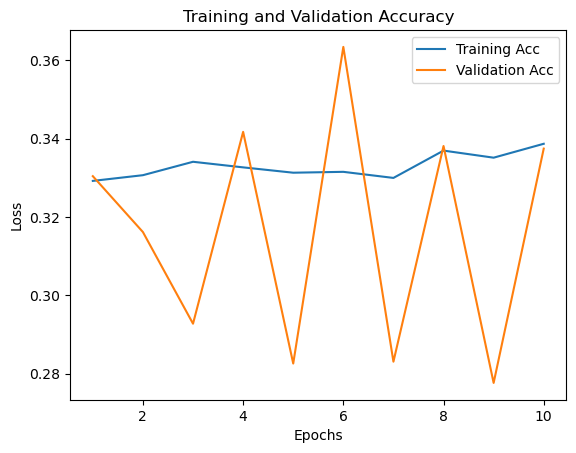

In [30]:
history_baseline = model_baseline.fit(train_ds, validation_data=val_ds, epochs=10)

history_dict = history_baseline.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Best Model: Feature Engineering - combining stress/anxiety and depression/suicidal classes

In [35]:
#change 5 to 0 and 6 to 2 in y_train
y_train_condensed = y_train['0'].map(lambda x: 0 if x == 5 else x)
y_train_condensed = y_train_condensed.map(lambda x: 2 if x == 6 else x)
y_test_condensed = y_test['0'].map(lambda x: 0 if x == 5 else x)
y_test_condensed = y_test_condensed.map(lambda x: 2 if x == 6 else x)
y_val_condensed = y_val['0'].map(lambda x: 0 if x == 5 else x)
y_val_condensed = y_val_condensed.map(lambda x: 2 if x == 6 else x)

#combining train, test and val into datasets
train_cond = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train_condensed))
test_cond = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test_condensed))
val_cond = tf.data.Dataset.from_tensor_slices((X_val_vectorized, y_val_condensed))

#configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_cond = train_cond.cache().prefetch(buffer_size=AUTOTUNE)
val_cond = val_cond.cache().prefetch(buffer_size=AUTOTUNE)
test_cond = test_cond.cache().prefetch(buffer_size=AUTOTUNE)

train_cond = train_cond.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_cond = train_cond.batch(64)
val_cond = val_cond.map(lambda x, y: (tf.cast(x, tf.float32), y))
val_cond = val_cond.batch(64)
test_cond = test_cond.map(lambda x, y: (tf.cast(x, tf.float32), y))
test_cond = test_cond.batch(64)

In [36]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
embedding_dim = 48

model_cond = tf.keras.Sequential([
    layers.Embedding(10000, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(7, activation='softmax')
])

model_cond.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5536 - loss: 1.1468 - val_accuracy: 0.7117 - val_loss: 0.8073
Epoch 2/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6809 - loss: 0.8920 - val_accuracy: 0.7882 - val_loss: 0.6546
Epoch 3/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7331 - loss: 0.7519 - val_accuracy: 0.7535 - val_loss: 0.6397
Epoch 4/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7637 - loss: 0.6750 - val_accuracy: 0.7974 - val_loss: 0.5858
Epoch 5/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7773 - loss: 0.6318 - val_accuracy: 0.8135 - val_loss: 0.5289
Epoch 6/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7911 - loss: 0.5976 - val_accuracy: 0.8080 - val_loss: 0.5158
Epoch 7/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7997 - loss: 0.5771 - val_accuracy: 0.8090 - val_loss: 0.5419
Epoch 8/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8053 - loss: 0.5615 - val_accuracy: 0.

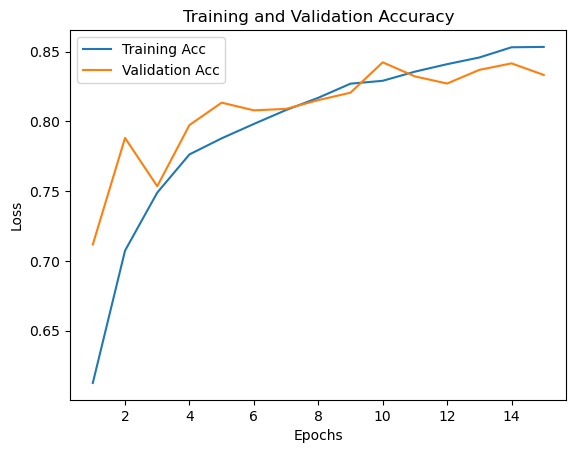

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_cond.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

history_cond = model_cond.fit(
    train_cond,
    validation_data=val_cond,
    epochs=50,
    callbacks=[early_stopping]
)

history_dict_3 = history_cond.history
acc = history_dict_3['accuracy']
val_acc = history_dict_3['val_accuracy']
loss = history_dict_3['loss']
val_loss = history_dict_3['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [38]:
#testing model on test data
y_test_pred = model_cond.predict(X_test_vectorized)
y_test_pred = np.argmax(y_test_pred, axis=1)
test_f1 = f1(y_test_condensed, y_test_pred, average='weighted')
print(f"Test F1 Score: {test_f1}")
print("Test Classification Report:\n", classification_report(y_test_condensed, y_test_pred))

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
Test F1 Score: 0.8309894190045891
Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.53      0.64      1289
           1       0.86      0.61      0.71       539
           2       0.88      0.88      0.88      5183
           3       0.79      0.95      0.86      3281
           4       0.74      0.47      0.58       217

    accuracy                           0.84     10509
   macro avg       0.82      0.69      0.73     10509
weighted avg       0.84      0.84      0.83     10509



The model's F1 Score on the test data is ~83%.